In [109]:
import numpy as np
import cv2
import glob
import os
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [110]:
## camera calibration (from openCV docs):
## https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html
## and
## https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0

In [111]:
CHECKERBOARD = (6,8)

subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW+cv2.CALIB_RATIONAL_MODEL
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('raw_images/*.jpg')

In [112]:
%%time
for fname in images:
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)

CPU times: user 7min 47s, sys: 10.1 s, total: 7min 57s
Wall time: 7min 57s


In [140]:
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

In [141]:
%%time
## calibrate fisheye
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))

CPU times: user 1.19 s, sys: 46.3 ms, total: 1.23 s
Wall time: 1.02 s


In [142]:
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

Found 124 valid images for calibration
DIM=(3072, 2048)
K=np.array([[1511.7515811351727, 0.0, 1496.5712039727023], [0.0, 1497.8201412252645, 1034.2071726674196], [0.0, 0.0, 1.0]])
D=np.array([[-0.03820374941567194], [-0.010632408359622545], [0.010231867812191526], [-0.0034649456540657756]])


## undistort images

In [143]:
# img = cv2.imread('2_9_2022_test_images/West_2022-02-09_160239.jpg')
img = cv2.imread('raw_images/calib_right_137.jpg')
h,  w = img.shape[:2]

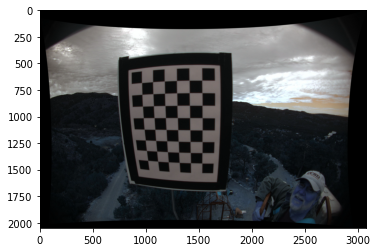

In [144]:
## trying with "standard" method in openCV docs
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, D, (w,h), 1, (w,h))
result_1 = cv2.undistort(img, K, D, None, newcameramtx)
# result_1 = cv2.undistort(img, K, D, None)
cv2.imwrite("undistort_test.jpg", result_1)
plt.imshow(result_1)

In [145]:
print(K)

[[1.51175158e+03 0.00000000e+00 1.49657120e+03]
 [0.00000000e+00 1.49782014e+03 1.03420717e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [184]:
balance = 1.0
dim2=None
dim3=None

# test on 1 image
# img = cv2.imread('2_9_2022_test_images/West_2022-02-09_160239.jpg')
img = cv2.imread('2_9_2022_test_images/North_2022-02-09_160021_image.jpg')
# img = cv2.imread('raw_images/calib_right_120.jpg')
# img = np.ones((2048, 3072))

dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
if not dim2:
    dim2 = dim1
if not dim3:
#     dim3 = dim1
    scale = 1.85
    dim3 = (int(dim1[0]*scale), int(dim1[1]*scale))
    
assert K[2][2] == 1.0

# This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. 
# OpenCV document failed to make this clear!
new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, dim2, np.eye(3), balance=balance)

new_K[0][2] = 2500
new_K[1][2] = 1800


## using undistort:
# result_2 = cv2.undistort(img, K, D, None, new_K)

map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

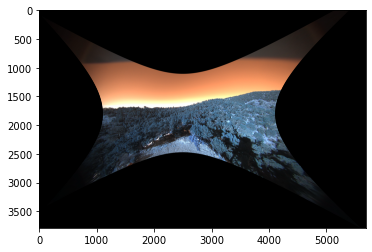

In [185]:
plt.imshow(undistorted_img)

In [186]:
cv2.imwrite("undistort_test.jpg", undistorted_img)

True

In [39]:
## clearly that did not work. 
## lets find the proper translation vector for new_K
print(new_K @ np.array([[0],
                        [0],
                        [1]]))

print(new_K @ np.array([[3072],
                        [0],
                        [1]]))

print(new_K @ np.array([[0],
                        [2048],
                        [1]]))

print(new_K @ np.array([[3072],
                        [2048],
                        [1]]))

[[1.46820733e+03]
 [1.03399320e+03]
 [1.00000000e+00]]
[[2.52129043e+06]
 [1.03399320e+03]
 [1.00000000e+00]]
[[1.46820733e+03]
 [1.66543465e+06]
 [1.00000000e+00]]
[[2.52129043e+06]
 [1.66543465e+06]
 [1.00000000e+00]]


In [128]:
print(2.52129043e+06 - 1.46820733e+03)
print(2.52129043e+06)

2519822.22267
2521290.43


In [ ]:
# img = cv.imread('images/found/calib_right_138.jpg')
# h,  w = img.shape[:2]
# newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
#
# ###### cv2.remap
# mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
# dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
#
# cv.imwrite('camera/' + ts + '/unwarpresult.png', dst)
# print("wrote unwarped img")
#
# mean_error = 0
# for i in range(len(objpoints)):
#     imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
#     error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
#     mean_error += error
# print( "total error: {}".format(mean_error/len(objpoints)) )